In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

dfS1 = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/bc_counts/FS1_counts.csv')
r_totS1 = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/bc_counts/FS1_Rtot.csv')
outliersS1 = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/outliers/FS1_outliers.csv')

RD_threshold=6 # defined in SI (sec S3.5) of Ascensao et al 2022
cond1=outliersS1['RD'] > RD_threshold
cond2=outliersS1['RD'] == -1
outliersS1=outliersS1[cond1 | cond2]
dfS1 = dfS1[~dfS1.barcode.isin(outliersS1.barcode)]

gene_index = []
for gene in dfS1["gene_ID"]:
    gene_index.append(gene)
#df.index = gene_index
dfS1.dropna(subset = ["gene_ID"], inplace = True)
dfS1 = dfS1.reset_index() 

all_genes = [] #list of all gene_IDs
for gene in gene_index:
    if gene != "NaN" and gene != "nan" and gene not in all_genes:
        all_genes.append(gene)
all_genes.pop(0)
print(len(all_genes))
print(len(dfS1))

r_totS1 = r_totS1.iloc[: , 1:]
dfS1.head()


3462
200567


,index,barcode,0_1,0_2,1,2,3,4,strand,pos,gene_ID,type,gene_symbol,description
0,34,GACTGGACTCTGACTACAAA,13,35,57,17,26,4,-,263938.0,ECB_00238,cds,phoE,outer membrane phosphoporin protein E
1,35,CCTAAGCGCTTACCCCAACC,42,116,72,72,21,14,+,2881032.0,ECB_02693,cds,yqeG,predicted transporter
2,36,TCGGACCCAGCTTGGAATAA,48,107,75,68,60,41,+,4065973.0,ECB_03781,cds,yiiG,hypothetical protein
3,37,TACCTCGGTCAAGGCGTCTA,8,35,0,7,0,0,-,2824332.0,ECB_02648,cds,NaN,L-fuculose phosphate aldolase
4,40,TATGATTCACCTCTTTATAC,21,32,17,25,26,20,-,1790824.0,ECB_01700,cds,cedA,cell division modulator


In [2]:
all_dfs = {} #dictionary of gene_ID to corresponding dataframe

for gene in all_genes:            
    all_dfs[gene] = dfS1[dfS1.gene_ID == gene]  

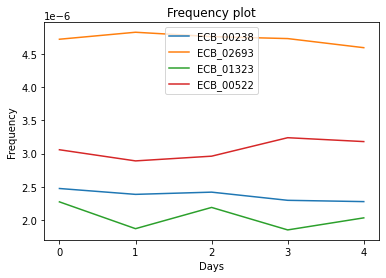

In [3]:
RtotS1_dict = dict(zip(r_totS1.columns.values, r_totS1.iloc[0].values))

#days
days = [0, 1, 2, 3, 4]

#function that takes the frequency average of a column (for a certain day)
def avg_freq(df, day, Rtot_dict):
    freq_vals = [] #all frequency values
    for count in df[day]:
        freq = count/Rtot_dict[day]
        freq_vals.append(freq)
    avg = np.sum(freq_vals)/len(freq_vals) #avg of all frequency values
    return avg
    
#function that yields average frequency of all barcodes in a single gene over 5 days (0-4 days)
def freq_over_days(df, Rtot_dict):
    all_freqs = []
    for day in ["0_1","0_2","1","2","3","4"]:
        all_freqs.append(avg_freq(df, day, Rtot_dict))
    day0 = (all_freqs[0]+all_freqs[1])/2
    all_freqs.pop(0)
    all_freqs.pop(0)
    all_freqs.insert(0, day0)
    #print(all_freqs)
    return all_freqs

def plot_freq(freq_array, gene):
    days = [0, 1, 2, 3, 4]
    plt.plot(days, freq_array, label = gene)
    plt.xticks(np.arange(0,len(days),1))
    #plt.ylim([0.85e-5,1.1e-5])
    plt.xlabel("Days")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Frequency plot")
    
plot_freq(freq_over_days(all_dfs["ECB_00238"], RtotS1_dict),"ECB_00238")
plot_freq(freq_over_days(all_dfs["ECB_02693"], RtotS1_dict), "ECB_02693")
plot_freq(freq_over_days(all_dfs["ECB_01323"], RtotS1_dict),"ECB_01323")
plot_freq(freq_over_days(all_dfs["ECB_00522"], RtotS1_dict), "ECB_00522")

In [4]:
#discard of counts under an average of 40
def discard(df):
    to_discard = []
    for i in range(len(df)):
        sum = 0
        for day in ["0_1","0_2","1","2","3","4"]:
            sum += df.loc[i,day] 
        if sum/6 < 30: #average count across days is < 30 --> discard
            to_discard.append(i)
    return to_discard

dfS1_dropped = dfS1.copy()

dfS1_dropped.drop(labels=discard(dfS1), axis=0, inplace=True)
dfS1_dropped =  dfS1_dropped.groupby('gene_ID').filter(lambda x : len(x)>3)
print(len(discard(dfS1)))
dfS1_dropped = dfS1_dropped.reset_index() 
print(len(dfS1_dropped))
dfS1_dropped.head(50)

147312
51497


,level_0,index,barcode,0_1,0_2,1,2,3,4,strand,pos,gene_ID,type,gene_symbol,description
0,1,35,CCTAAGCGCTTACCCCAACC,42,116,72,72,21,14,+,2881032.0,ECB_02693,cds,yqeG,predicted transporter
1,2,36,TCGGACCCAGCTTGGAATAA,48,107,75,68,60,41,+,4065973.0,ECB_03781,cds,yiiG,hypothetical protein
2,6,44,ATTCCTGTTACTAGATCAAA,34,97,4,57,34,21,+,1468609.0,ECB_01382,cds,NaN,hypothetical protein
3,7,46,CCCCCCAGGCTCGTGACGCC,65,61,39,37,51,18,-,2392940.0,ECB_02257,cds,yfcO,hypothetical protein
4,8,48,AGTGATTGCGTATATCTGTT,46,38,24,25,46,9,+,2205123.0,ECB_02090,cds,yeiJ,predicted nucleoside transporter
5,9,49,GCCACAGCACCGGTCACACT,42,53,21,31,52,59,-,4437424.0,ECB_04099,cds,yjfF,predicted sugar transporter subunit
6,14,55,TTACCGACTACTCACATTGA,43,53,35,44,39,51,-,3789895.0,ECB_03531,cds,NaN,hypothetical protein
7,15,56,CGAACCCTCCGACGCGCTTT,7,46,31,66,23,8,-,3119814.0,ECB_02915,cds,ygiL,predicted fimbrial-like adhesin protein
8,16,57,CCCGACATCGCACGCAACGC,79,57,31,72,78,57,+,3584927.0,ECB_03356,cds,yhiD,predicted Mg(2+) transport ATPase inner membra...
9,20,61,CCCTCACCCTATTATCTGCC,36,39,29,38,20,34,-,2364812.0,ECB_02227,cds,yfcG,predicted glutathione S-transferase


In [5]:
#dictionary with days and corresponding Rtot
RtotS1_dict = dict(zip(r_totS1.columns.values, r_totS1.iloc[0].values))

dfS1_freqs = dfS1_dropped.copy() #df with freqs of all days

def frequency(df_freqs, rtot):
    for day in ["0_1","0_2","1","2","3","4"]:
        freq_vals = [] #all frequency values
        for count in df_freqs[day]:
            freq = count/rtot[day]
            freq_vals.append(freq)
        df_freqs["%s_freq" % day] = freq_vals
    df_freqs.insert(15, "0_freq", df_freqs[["0_1_freq", "0_2_freq"]].mean(axis=1))
    
frequency(dfS1_freqs, RtotS1_dict)
dfS1_freqs.head(50)

,level_0,index,barcode,0_1,0_2,1,2,3,4,strand,...,type,gene_symbol,description,0_freq,0_1_freq,0_2_freq,1_freq,2_freq,3_freq,4_freq
0,1,35,CCTAAGCGCTTACCCCAACC,42,116,72,72,21,14,+,...,cds,yqeG,predicted transporter,0.000008,4.366829e-06,0.000011,8.171155e-06,0.000007,2.433273e-06,0.000002
1,2,36,TCGGACCCAGCTTGGAATAA,48,107,75,68,60,41,+,...,cds,yiiG,hypothetical protein,0.000007,4.990662e-06,0.000010,8.511620e-06,0.000007,6.952209e-06,0.000005
2,6,44,ATTCCTGTTACTAGATCAAA,34,97,4,57,34,21,+,...,cds,NaN,hypothetical protein,0.000006,3.535052e-06,0.000009,4.539530e-07,0.000006,3.939585e-06,0.000003
3,7,46,CCCCCCAGGCTCGTGACGCC,65,61,39,37,51,18,-,...,cds,yfcO,hypothetical protein,0.000006,6.758188e-06,0.000006,4.426042e-06,0.000004,5.909377e-06,0.000002
4,8,48,AGTGATTGCGTATATCTGTT,46,38,24,25,46,9,+,...,cds,yeiJ,predicted nucleoside transporter,0.000004,4.782718e-06,0.000004,2.723718e-06,0.000003,5.330027e-06,0.000001
5,9,49,GCCACAGCACCGGTCACACT,42,53,21,31,52,59,-,...,cds,yjfF,predicted sugar transporter subunit,0.000005,4.366829e-06,0.000005,2.383253e-06,0.000003,6.025247e-06,0.000008
6,14,55,TTACCGACTACTCACATTGA,43,53,35,44,39,51,-,...,cds,NaN,hypothetical protein,0.000005,4.470801e-06,0.000005,3.972089e-06,0.000005,4.518936e-06,0.000007
7,15,56,CGAACCCTCCGACGCGCTTT,7,46,31,66,23,8,-,...,cds,ygiL,predicted fimbrial-like adhesin protein,0.000002,7.278048e-07,0.000004,3.518136e-06,0.000007,2.665013e-06,0.000001
8,16,57,CCCGACATCGCACGCAACGC,79,57,31,72,78,57,+,...,cds,yhiD,predicted Mg(2+) transport ATPase inner membra...,0.000007,8.213797e-06,0.000005,3.518136e-06,0.000007,9.037871e-06,0.000007
9,20,61,CCCTCACCCTATTATCTGCC,36,39,29,38,20,34,-,...,cds,yfcG,predicted glutathione S-transferase,0.000004,3.742996e-06,0.000004,3.291160e-06,0.000004,2.317403e-06,0.000004


In [6]:
dfS1_x = dfS1_freqs.copy() #df with freqs of VST (variance stabilizing transformation)

def x_freq(df_x):
    for freq in ["0_freq","1_freq","2_freq","3_freq","4_freq"]:
        x_vals = [] #all frequency values
        for count in df_x[freq]:
            count = np.sqrt(count)
            x_vals.append(count)
        df_x["x(%s)" % freq] = x_vals

x_freq(dfS1_x)  
dfS1_x = dfS1_x.drop(dfS1_x.columns[[0, 1, 3, 4, 5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21]], axis=1)
dfS1_x.head(50)

,barcode,strand,pos,gene_ID,type,gene_symbol,description,x(0_freq),x(1_freq),x(2_freq),x(3_freq),x(4_freq)
0,CCTAAGCGCTTACCCCAACC,+,2881032.0,ECB_02693,cds,yqeG,predicted transporter,0.002744,0.002859,0.002719,0.001560,0.001350
1,TCGGACCCAGCTTGGAATAA,+,4065973.0,ECB_03781,cds,yiiG,hypothetical protein,0.002725,0.002917,0.002643,0.002637,0.002310
2,ATTCCTGTTACTAGATCAAA,+,1468609.0,ECB_01382,cds,NaN,hypothetical protein,0.002498,0.000674,0.002420,0.001985,0.001654
3,CCCCCCAGGCTCGTGACGCC,-,2392940.0,ECB_02257,cds,yfcO,hypothetical protein,0.002488,0.002104,0.001949,0.002431,0.001531
4,AGTGATTGCGTATATCTGTT,+,2205123.0,ECB_02090,cds,yeiJ,predicted nucleoside transporter,0.002035,0.001650,0.001602,0.002309,0.001082
5,GCCACAGCACCGGTCACACT,-,4437424.0,ECB_04099,cds,yjfF,predicted sugar transporter subunit,0.002151,0.001544,0.001784,0.002455,0.002772
6,TTACCGACTACTCACATTGA,-,3789895.0,ECB_03531,cds,NaN,hypothetical protein,0.002163,0.001993,0.002126,0.002126,0.002577
7,CGAACCCTCCGACGCGCTTT,-,3119814.0,ECB_02915,cds,ygiL,predicted fimbrial-like adhesin protein,0.001576,0.001876,0.002604,0.001632,0.001021
8,CCCGACATCGCACGCAACGC,+,3584927.0,ECB_03356,cds,yhiD,predicted Mg(2+) transport ATPase inner membra...,0.002595,0.001876,0.002719,0.003006,0.002724
9,CCCTCACCCTATTATCTGCC,-,2364812.0,ECB_02227,cds,yfcG,predicted glutathione S-transferase,0.001915,0.001814,0.001976,0.001522,0.002104


In [7]:
dfS1_x_corr = dfS1_x.copy() #df with corrected freqs of VST (variance stabilizing transformation)
df_s = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/fitness/FS1_fitness.csv')
df_t_xbar = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/meanfitness/FS1_xbar.csv')

df_t_xbar.head()

,Unnamed: 0,Day label,xbar,stderr,gens
0,0,1,0.010207,0.000375,6.643856
1,1,2,0.005280,0.000195,13.287712
2,2,3,0.003811,0.000151,19.931569
3,3,4,0.003251,0.000140,26.575425


In [8]:
tS1_dict = dict(zip(df_t_xbar["Day label"], df_t_xbar["gens"]))
xbarS1_dict = dict(zip(df_t_xbar["Day label"], df_t_xbar["xbar"]))
sS1_dict = dict(zip(df_s["gene_ID"], df_s["s"]))

print(tS1_dict)
print(xbarS1_dict)

{1: 6.64385619, 2: 13.28771238, 3: 19.93156857, 4: 26.57542476}
{1: 0.010207445152528943, 2: 0.005279710051303896, 3: 0.003810948070721187, 4: 0.003250505626719311}


In [9]:

dfS1_x_corr = dfS1_x.copy()

#dropping rows/gene_IDs with no "s" value
no_s = []
for i in range(len(dfS1_x_corr)):
    index_gene = dfS1_x_corr.columns.get_loc("gene_ID")
    if dfS1_x_corr.iloc[i,index_gene] not in sS1_dict.keys():
        no_s.append(i)
dfS1_x_corr.drop(no_s, axis=0, inplace=True)
dfS1_x_corr = dfS1_x_corr.reset_index()
dfS1_x_corr = dfS1_x_corr.drop(dfS1_x_corr.columns[[0]], axis=1)

#calculating x_corrected
days = [1, 2, 3, 4]
x_freqs = ["x(1_freq)","x(2_freq)","x(3_freq)","x(4_freq)"]

def x_corr_form(day, x, s_dict, t_dict, xbar_dict, df_x_corr):
    x_corr_vals = []
    for i in range(len(df_x_corr)):
        #index = day-1
        index_0 = df_x_corr.columns.get_loc("x(0_freq)")
        index_t = df_x_corr.columns.get_loc(x)
        x_0 = df_x_corr.iloc[i, index_0]
        x_t = df_x_corr.iloc[i, index_t]
        index_gene = df_x_corr.columns.get_loc("gene_ID")
        gene_ID = df_x_corr.iloc[i, index_gene]
        if gene_ID in s_dict.keys():
            s = s_dict[gene_ID]
        else:
            continue;
        t = t_dict[day]
        xbar = xbar_dict[day]
        x_corr = x_corr_ele(x_0, x_t, s, xbar, t)
        x_corr_vals.append(x_corr)
    return x_corr_vals
        
def x_corr_ele(x_0, x_t, s, xbar, t):
    x_corr = x_t - (x_0*math.exp((s-xbar)* (t/2)))
    return x_corr

#x_corr
for day, x in zip(days, x_freqs):
    x_corr = x_corr_form(day, x, sS1_dict, tS1_dict, xbarS1_dict, dfS1_x_corr)
    dfS1_x_corr["x_corr(%s)" % day] = x_corr
    
print(len(dfS1_x_corr))
dfS1_x_corr.head(50)

44103


,barcode,strand,pos,gene_ID,type,gene_symbol,description,x(0_freq),x(1_freq),x(2_freq),x(3_freq),x(4_freq),x_corr(1),x_corr(2),x_corr(3),x_corr(4)
0,CCTAAGCGCTTACCCCAACC,+,2881032.0,ECB_02693,cds,yqeG,predicted transporter,0.002744,0.002859,0.002719,0.001560,0.001350,0.000198,0.000054,-0.001106,-0.001310
1,TCGGACCCAGCTTGGAATAA,+,4065973.0,ECB_03781,cds,yiiG,hypothetical protein,0.002725,0.002917,0.002643,0.002637,0.002310,0.000293,0.000030,0.000041,-0.000262
2,CCCCCCAGGCTCGTGACGCC,-,2392940.0,ECB_02257,cds,yfcO,hypothetical protein,0.002488,0.002104,0.001949,0.002431,0.001531,-0.000283,-0.000417,0.000089,-0.000782
3,AGTGATTGCGTATATCTGTT,+,2205123.0,ECB_02090,cds,yeiJ,predicted nucleoside transporter,0.002035,0.001650,0.001602,0.002309,0.001082,-0.000376,-0.000483,0.000166,-0.001113
4,GCCACAGCACCGGTCACACT,-,4437424.0,ECB_04099,cds,yjfF,predicted sugar transporter subunit,0.002151,0.001544,0.001784,0.002455,0.002772,-0.000574,-0.000371,0.000265,0.000553
5,CGAACCCTCCGACGCGCTTT,-,3119814.0,ECB_02915,cds,ygiL,predicted fimbrial-like adhesin protein,0.001576,0.001876,0.002604,0.001632,0.001021,0.000360,0.001098,0.000139,-0.000457
6,CCCGACATCGCACGCAACGC,+,3584927.0,ECB_03356,cds,yhiD,predicted Mg(2+) transport ATPase inner membra...,0.002595,0.001876,0.002719,0.003006,0.002724,-0.000613,0.000253,0.000567,0.000317
7,CCCTCACCCTATTATCTGCC,-,2364812.0,ECB_02227,cds,yfcG,predicted glutathione S-transferase,0.001915,0.001814,0.001976,0.001522,0.002104,-0.000060,0.000081,-0.000389,0.000179
8,GCCTTCCCCCCACGTCTGCA,-,2352777.0,ECB_02216,cds,yfbR,hypothetical protein,0.001948,0.001783,0.002584,0.001444,0.002253,-0.000068,0.000767,-0.000336,0.000513
9,CGTCCTGTCTCCAAACGAAA,+,3198194.0,ECB_02984,cds,tdcB,threonine dehydratase,0.002059,0.002566,0.002377,0.002455,0.001730,0.000613,0.000464,0.000585,-0.000094


In [10]:
#list of all x_corr(t) for each barcode:
xS1_corrs = dfS1_x_corr[["x_corr(1)","x_corr(2)","x_corr(3)","x_corr(4)"]].values.tolist()

def x_var(x_corrs, df_x_corr):
    x_c_var = []
    for x_c in x_corrs:
        x_var = np.var(x_c)
        x_c_var.append(x_var)
    df_x_corr["var(x_corr)"] = x_c_var

x_var(xS1_corrs, dfS1_x_corr)
dfS1_x_corr.head(50)  

,barcode,strand,pos,gene_ID,type,gene_symbol,description,x(0_freq),x(1_freq),x(2_freq),x(3_freq),x(4_freq),x_corr(1),x_corr(2),x_corr(3),x_corr(4),var(x_corr)
0,CCTAAGCGCTTACCCCAACC,+,2881032.0,ECB_02693,cds,yqeG,predicted transporter,0.002744,0.002859,0.002719,0.001560,0.001350,0.000198,0.000054,-0.001106,-0.001310,4.524255e-07
1,TCGGACCCAGCTTGGAATAA,+,4065973.0,ECB_03781,cds,yiiG,hypothetical protein,0.002725,0.002917,0.002643,0.002637,0.002310,0.000293,0.000030,0.000041,-0.000262,3.861233e-08
2,CCCCCCAGGCTCGTGACGCC,-,2392940.0,ECB_02257,cds,yfcO,hypothetical protein,0.002488,0.002104,0.001949,0.002431,0.001531,-0.000283,-0.000417,0.000089,-0.000782,9.698366e-08
3,AGTGATTGCGTATATCTGTT,+,2205123.0,ECB_02090,cds,yeiJ,predicted nucleoside transporter,0.002035,0.001650,0.001602,0.002309,0.001082,-0.000376,-0.000483,0.000166,-0.001113,2.064971e-07
4,GCCACAGCACCGGTCACACT,-,4437424.0,ECB_04099,cds,yjfF,predicted sugar transporter subunit,0.002151,0.001544,0.001784,0.002455,0.002772,-0.000574,-0.000371,0.000265,0.000553,2.098191e-07
5,CGAACCCTCCGACGCGCTTT,-,3119814.0,ECB_02915,cds,ygiL,predicted fimbrial-like adhesin protein,0.001576,0.001876,0.002604,0.001632,0.001021,0.000360,0.001098,0.000139,-0.000457,3.096820e-07
6,CCCGACATCGCACGCAACGC,+,3584927.0,ECB_03356,cds,yhiD,predicted Mg(2+) transport ATPase inner membra...,0.002595,0.001876,0.002719,0.003006,0.002724,-0.000613,0.000253,0.000567,0.000317,1.982289e-07
7,CCCTCACCCTATTATCTGCC,-,2364812.0,ECB_02227,cds,yfcG,predicted glutathione S-transferase,0.001915,0.001814,0.001976,0.001522,0.002104,-0.000060,0.000081,-0.000389,0.000179,4.624818e-08
8,GCCTTCCCCCCACGTCTGCA,-,2352777.0,ECB_02216,cds,yfbR,hypothetical protein,0.001948,0.001783,0.002584,0.001444,0.002253,-0.000068,0.000767,-0.000336,0.000513,1.943125e-07
9,CGTCCTGTCTCCAAACGAAA,+,3198194.0,ECB_02984,cds,tdcB,threonine dehydratase,0.002059,0.002566,0.002377,0.002455,0.001730,0.000613,0.000464,0.000585,-0.000094,8.185595e-08


In [11]:
#create df with variances and corresponding geneIDs
def list_genes(df_x_corr):
    updated_genes = []
    for gene in df_x_corr["gene_ID"].tolist():
        if gene not in updated_genes:
            updated_genes.append(gene)
    return updated_genes

#getting average variance of barcodes in each gene:
def avg_var(df_x_corr):
    avg_vars = []
    std_vars = []
    for gene in list_genes(df_x_corr):
        df_gene = df_x_corr.loc[df_x_corr["gene_ID"] == gene]
        x_vars = df_gene["var(x_corr)"].mean()
        avg_vars.append(x_vars)
        x_std = np.sqrt(x_vars)
        std_vars.append(x_std)
    return [avg_vars, std_vars]

bcS1_data = {"gene_ID": list_genes(dfS1_x_corr), "avg_var(x_corr)": avg_var(dfS1_x_corr)[0], "std(x_corr)": avg_var(dfS1_x_corr)[1]}
dfS1_bc = pd.DataFrame(bcS1_data)
dfS1_bc = dfS1_bc.sort_values(by = 'avg_var(x_corr)', ascending=[False])
dfS1_bc = dfS1_bc.reset_index() 
dfS1_bc.head(50)

,index,gene_ID,avg_var(x_corr),std(x_corr)
0,1654,ECB_03131,7.914039e-07,0.000890
1,1206,ECB_02465,6.569085e-07,0.000810
2,1374,ECB_01320,6.428675e-07,0.000802
3,1786,ECB_03984,6.101486e-07,0.000781
4,1709,ECB_01514,6.027980e-07,0.000776
5,1289,ECB_04271,5.485799e-07,0.000741
6,1584,ECB_03229,5.267127e-07,0.000726
7,561,ECB_02164,5.228436e-07,0.000723
8,1779,ECB_02683,5.161638e-07,0.000718
9,1530,ECB_02308,5.074855e-07,0.000712


In [12]:
dfS1_bc.to_csv('FS1.csv')

In [13]:
#first 3 genes with highest variance:
def plot_x(df_gene, gene_ID):
    for i in range(len(df_gene)):
        barcode = df_gene.iloc[i,0]
        x_array = df_gene.iloc[i,8:12].tolist()
        days = [1, 2, 3, 4]
        plt.plot(days, x_array)#, label = barcode)
        plt.xticks(np.arange(1,len(days)+1,1))
        plt.xlabel("Days")
        plt.ylabel("x(t)")
        plt.ylim([-0.02,0.02])
        #plt.legend()
        plt.title(gene_ID)
    plt.show()
    
def plot_x_corr(df_gene, gene_ID):
    for i in range(len(df_gene)):
        barcode = df_gene.iloc[i,0]
        x_array = df_gene.iloc[i,12:16].tolist()
        days = [1, 2, 3, 4]
        plt.plot(days, x_array)#, label = barcode)
        plt.xticks(np.arange(1,len(days)+1,1))
        plt.xlabel("Days")
        plt.ylabel("x_corr(t)")
        plt.ylim([-0.02,0.02])
        #plt.legend()
        plt.title(gene_ID)
    plt.show()

def plot_gene_x(gene_ID, df_x_corr):
    #gene_ID = df_bc.iloc[i, 1] #1 is index of gene_ID
    df_gene = df_x_corr.loc[df_x_corr["gene_ID"] == gene_ID]
    plot_x(df_gene, gene_ID)
    
def plot_gene_x_corr(gene_ID, df_x_corr):
    #gene_ID = df_bc.iloc[i, 1] #1 is index of gene_ID
    df_gene = df_x_corr.loc[df_x_corr["gene_ID"] == gene_ID]
    plot_x_corr(df_gene, gene_ID)
    
def plot_first(df_bc, df_x_corr, n): #number of first nth genes to plot for df_bc
    gene_order = df_bc["gene_ID"].tolist()
    for gene in gene_order[0:n]:
        plot_gene_x(gene, df_x_corr)
        plot_gene_x_corr(gene, df_x_corr)
        
def plot_last(df_bc, df_x_corr, n): #number of first nth genes to plot for df_bc
    gene_order = df_bc["gene_ID"].tolist()
    for gene in gene_order[-n:]:
        plot_gene_x(gene, df_x_corr)
        plot_gene_x_corr(gene, df_x_corr)

In [14]:
all_dfs["ECB_00972"]

,index,barcode,0_1,0_2,1,2,3,4,strand,pos,gene_ID,type,gene_symbol,description
61197,87807,GACCGCACTGCCCTCAGACA,11,5,13,10,14,5,+,1047216.0,ECB_00972,cds,yccX,predicted acylphosphatase
72778,104313,ATGCAACCAGGAGTGATACG,19,20,11,9,0,0,+,1047336.0,ECB_00972,cds,yccX,predicted acylphosphatase
81313,116465,GCGGCACCTCCCCCCCCGTC,6,10,34,37,22,14,-,1047234.0,ECB_00972,cds,yccX,predicted acylphosphatase
84729,121392,ATCCCTACATTGCTCTAGCG,77,66,0,18,57,31,-,1047234.0,ECB_00972,cds,yccX,predicted acylphosphatase


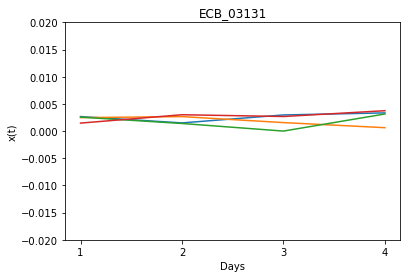

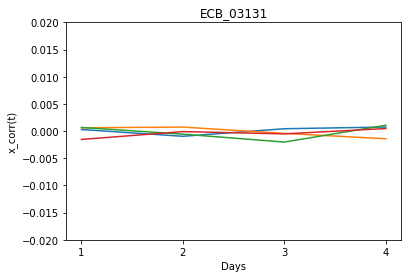

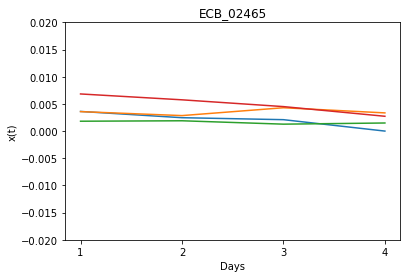

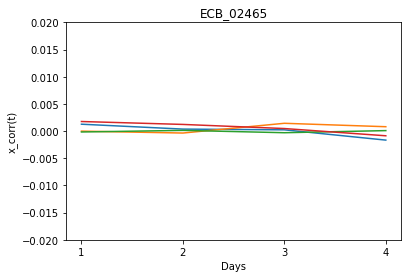

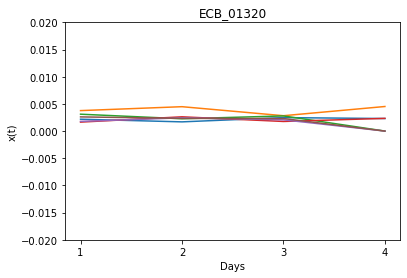

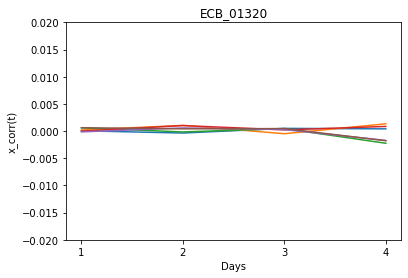

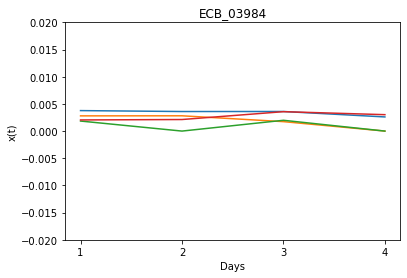

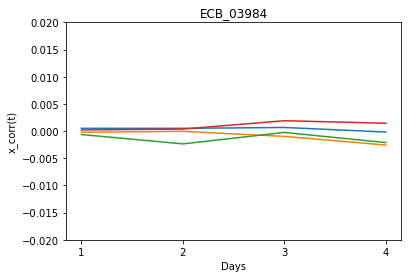

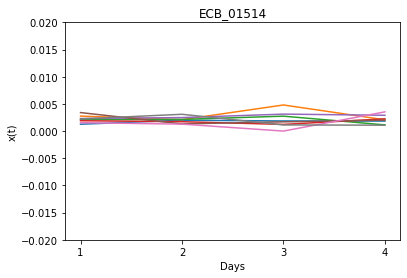

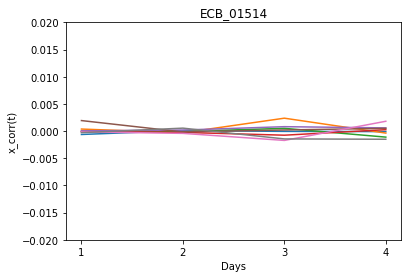

In [15]:
plot_first(dfS1_bc, dfS1_x_corr, 5)

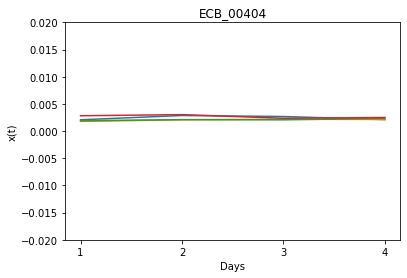

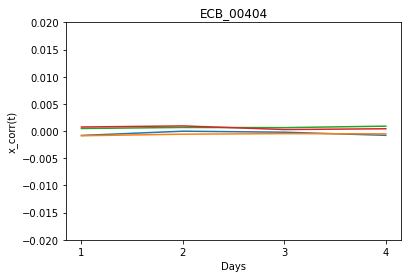

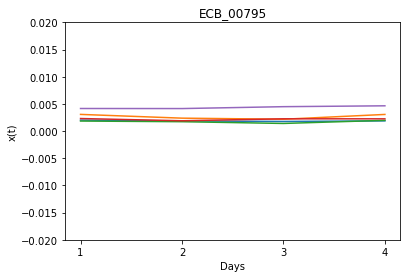

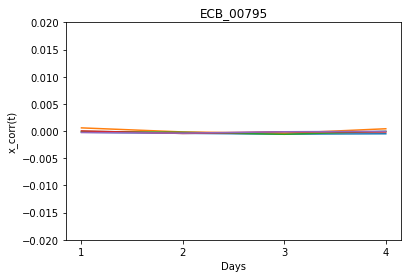

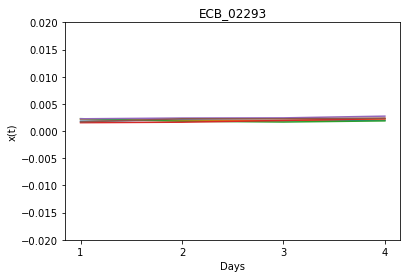

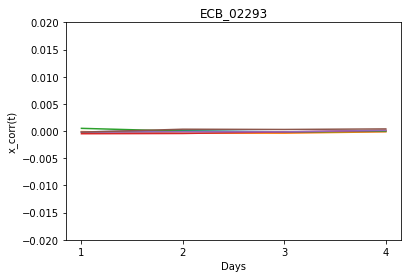

In [16]:
plot_last(dfS1_bc, dfS1_x_corr, 3)